<a href="https://colab.research.google.com/github/JeremySpradlin/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Jeremy_Spradlin_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [74]:
#SKLearn Imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

#General Imports
import category_encoders as ce
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

#Import for plotting the decision tree
import graphviz
from sklearn.tree import export_graphviz


# Train/Validate/Test split

Since the data is already split into training and testing sets from the source, we will further split the training set into training and validation sets

In [6]:
#Perform our train/test/split on the data
train, val  = train_test_split(train, train_size=0.8, test_size=0.2, stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

# Baselines
Now that we have out data split out into train/val/test sets, we will use our training set to determine our baseline using `status_group`

In [7]:
train['status_group'].value_counts()

functional                 25807
non functional             18259
functional needs repair     3454
Name: status_group, dtype: int64

In [17]:
print(25807 / (25807 + 18259 + 3454))


0.5430765993265994


Our training accuracy baseline is approximately 54%

# Select Features
Below we will select our features to use, and further clean the data

First, we will need to fix the `null island` results in our geo data

In [19]:
train.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [21]:
#Create a function to wrangle our data by fixing the null island values in the geo data as well as 
#remove any redundant columns
def wrangle_data(X):
  """Function for wrangling all of our data sets in the same manner"""

  #Prevent a SettingWithCopyWarning
  X = X.copy()

  #Replace the near-0 values in latitude with 0's for easier handling
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #Now we will replace the 0's with null values for easier handling
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #Drop redundnat columns
  red_cols = ['quantity_group']
  X = X.drop(columns=red_cols)

  #Return the wrangled dataframe
  return X

  

In [24]:
#Perform our wrangling function on our 3 datasets
train = wrangle_data(train)
val = wrangle_data(val)
test = wrangle_data(test)

train.shape, val.shape, test.shape

((47520, 40), (11880, 40), (14358, 39))

## Select our features

Now that we have wrangled our data, took care of some dirty data, and cleaned up redundant columns, we will select our features to use on our model

In [25]:
#Our target column
target = 'status_group'

# Strip out the target and id columns
train_features = train.drop(columns=[target, 'id'])

#Get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

#Create a list of all nonnumerica features with a cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

#Combine the lists
features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


# Create a Pipeline and fit our data to it

In [28]:
#Let's check plotting out some of our geo data to verify that we did, in fact, take care of the null island values
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [29]:
#Split our train/val/test sets into their feature matrices and target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
#No y_test since no lables were provided with the testing dataset

In [33]:
#Create our pipeline
dt_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

dt_model.fit(X_train, y_train);

In [34]:
#Check our initial metrics
print('Training Accuracy', dt_model.score(X_train, y_train))
print('Validation Accuracy', dt_model.score(X_val, y_val))

Training Accuracy 0.9954755892255892
Validation Accuracy 0.7594276094276095


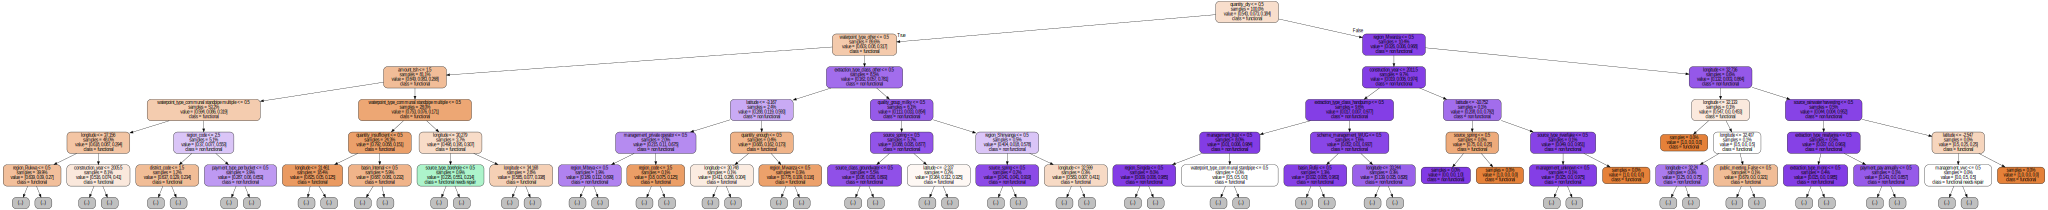

In [38]:
#Plot our decision tree to analyze for reasons for overfitting

model = dt_model.named_steps['decisiontreeclassifier']
encoder = dt_model.named_steps['onehotencoder']
encoded_cols = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None,
                           max_depth=5,
                           feature_names=encoded_cols,
                           class_names=model.classes_,
                           impurity=False,
                           filled=True,
                           proportion=True,
                           rounded=True)

display(graphviz.Source(dot_data))

With a training accuracy of above 99% and a validation accuracy of only 76%, it is reasonable to assume that this model is overfit, as DecisionTrees are known to do, likely due to over-complexity in our decision tree that we can see in the very expansive model above.

We can reduce this over-complexity by adjusting the `max_depth` flag inside the DecisionTreeClassifier

In [39]:
dt_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42, max_depth=7)
)

dt_model.fit(X_train, y_train);

In [40]:
#Recheck our new metrics
print('Training Accuracy', dt_model.score(X_train, y_train))
print('Validation Accuracy', dt_model.score(X_val, y_val))

Training Accuracy 0.7295454545454545
Validation Accuracy 0.725


Now we see that the training and validation accuracy scores are MUCH closer to each other, indicating that we have solved our over-fitting problem.

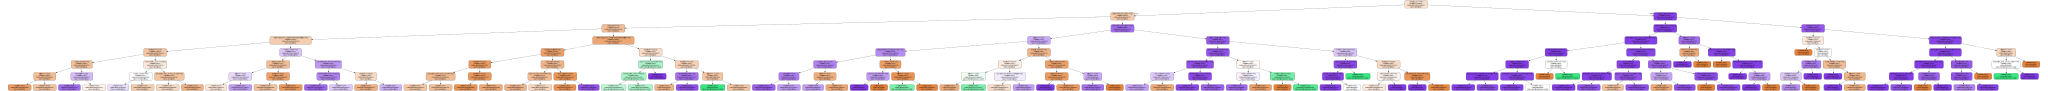

In [53]:
#Replotting our new decision tree
model = dt_model.named_steps['decisiontreeclassifier']
encoder = dt_model.named_steps['onehotencoder']
encoded_cols = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None,
                           max_depth=7,
                           feature_names=encoded_cols,
                           class_names=model.classes_,
                           impurity=False,
                           filled=True,
                           proportion=True,
                           rounded=True)

display(graphviz.Source(dot_data))

# Accuracy Scores

Below we will display our accuracy scores again for our most current models.  Our baseline score to beat was `54%`.

In [41]:
#Resharing our model metrics
print('Training Accuracy', dt_model.score(X_train, y_train))
print('Validation Accuracy', dt_model.score(X_val, y_val))

Training Accuracy 0.7295454545454545
Validation Accuracy 0.725


#COMPETITION!!!!!!!

Below we're going to play with our model and see if we can't get better scores for submission to the kaggle challenge

In [78]:
#Create a new model
dt_model1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    IterativeImputer(),
    DecisionTreeClassifier(random_state=42, max_depth=7)
)

dt_model1.fit(X_train, y_train);

In [79]:
#Model metrics
print('Training Accuracy', dt_model1.score(X_train, y_train))
print('Validation Accuracy', dt_model1.score(X_val, y_val))

Training Accuracy 0.7295244107744108
Validation Accuracy 0.7244949494949495


# Feature Importance

Below we will obtain and plot our feature importances from our model

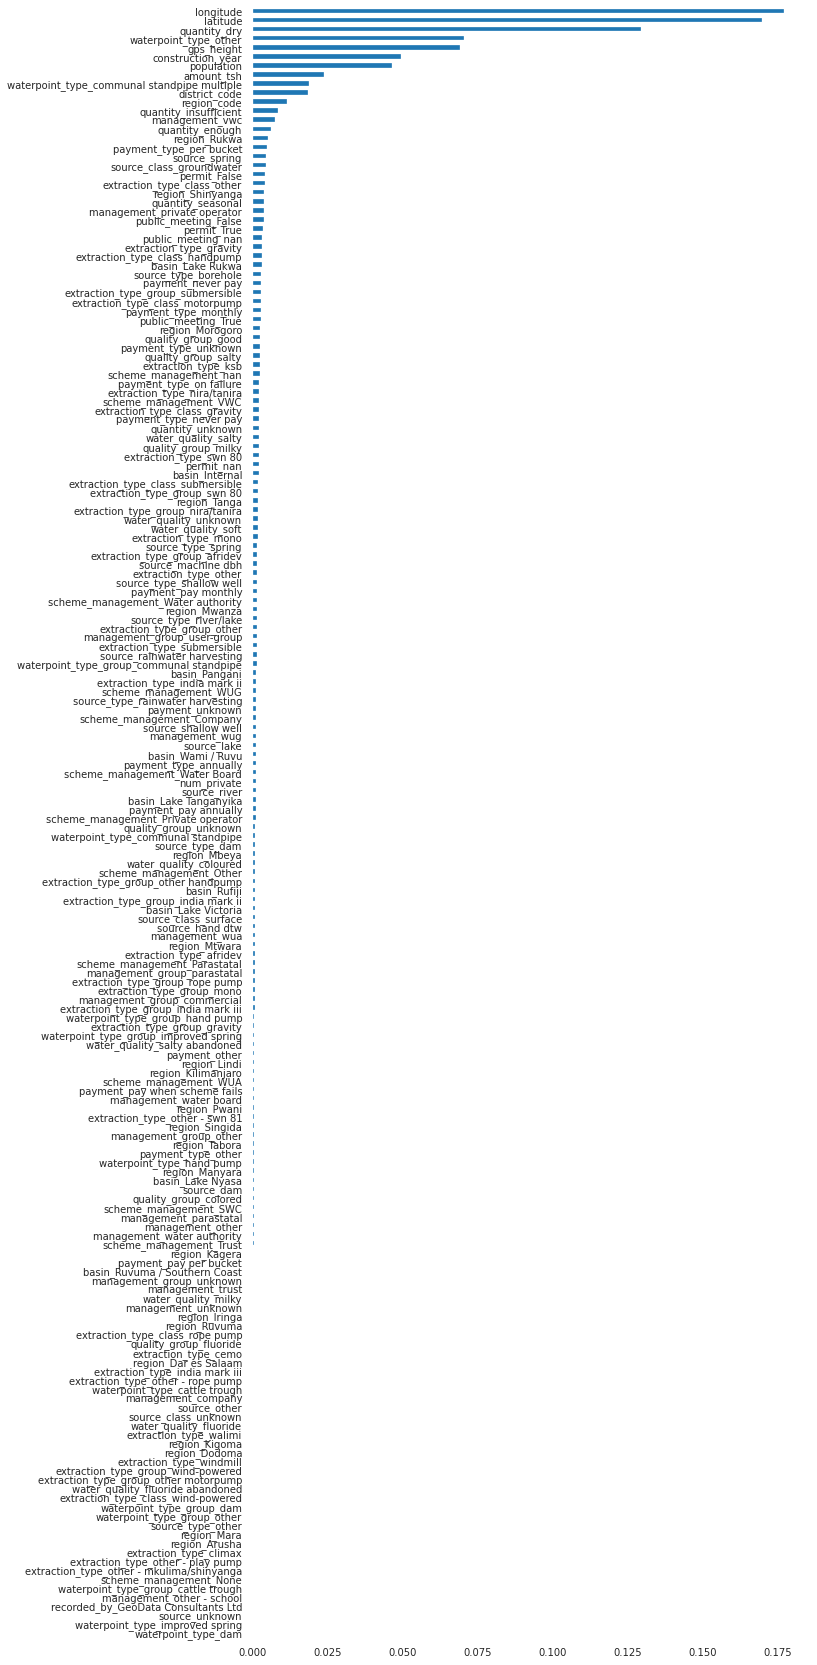

In [49]:
#Create and plot our decision tree classifier's feature importance

encoder = dt_model.named_steps['onehotencoder']
encoded_cols = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns). #I do not understand why model is used here rather than dt_model, or how it works, given that I have not instantiated 'model'?

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

In [71]:
#Export our prediction csv to submit on Kaggle
y_pred = dt_model.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('jeremy-spradlin-submission.csv', index=False)

# Stretch GOOOOOOOOOOAAAAAAAALLLLLLLLLSSSSSSSSSS!

Below we will be doing the stretch goals, starting first with writing a function(s) to handle all of the finger work we did above.

### Notice:  We will be brnaching out new models from our split datasets above rather than manipulating our existing models

In [56]:
#Verify our datasets are still good
train.shape, val.shape, test.shape

((47520, 40), (11880, 40), (14358, 39))

In [57]:
#Function that was used above to wrangle our data
def wrangle_data(X):
  """Function for wrangling all of our data sets in the same manner"""

  #Prevent a SettingWithCopyWarning
  X = X.copy()

  #Replace the near-0 values in latitude with 0's for easier handling
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #Now we will replace the 0's with null values for easier handling
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #Drop redundnat columns
  red_cols = ['quantity_group']
  X = X.drop(columns=red_cols)

  #Return the wrangled dataframe
  return X

### Note: Since our train/val/test data has already been wrangled by the above function, we will not be rerunning it here.

## Graph Visualizations

In [58]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [70]:
px.scatter(train, x='date_recorded', y='population', color='status_group', opacity=0.5)